In [ ]:
#se necessario descomentar para instalar
#instalacao da biblioteca mip (foi necessario no colab)
#pip install mip 

In [2]:
import mip
import numpy as np
import matplotlib.pyplot as pp

In [3]:
#n -> numero de nos
#(n^2 variaveis)
n = 15

#definomos uma seed para
#sempre gerar os mesmos resultados

np.random.seed(n**2)


#cria os nos
#nesse caso vao ser representados por pontos no plano cartesiano (x,y)
nos = []

#multiplicamos por 32 para ter valores mais "reais" do tema do problema
for i in range(n):
  nos.append(32 * np.random.normal( size = ( 2,)))

#cria uma matriz n por n de 0
c = np.zeros((n,n)) 

#cada posicao c[i][j] guarda a distancia entre os nos (i + 1) e (j + 1)
#exemplo: c[0][2] -> distancia entre o no 1 e 3
#a distancia entre o no e ele proprio e disconsiderado
for i in range(n):
  for j in range(i + 1, n):
    c[i,j] = np.linalg.norm(nos[i] - nos[j]) #distancia euclidiana
    c[j,i] = c[i,j]                          #custo de ida = ao custo de volta

In [4]:
#define o modelo para minimizar e escolhe qual solver
m = mip.Model(sense = mip.MINIMIZE, solver_name = mip.CBC)

#cria as variaveis x[i][j], i, j <= n
#define as variaveis x como binarias 
#x[i][j] = 1 se passar pela aresta que liga o no[i] ao no[j]
#x[i][j] = 0 caso contrario
x = []
for i in range(n):
  x.append([m.add_var(var_type = mip.BINARY, name = 'x_(%i,%i)' % ( i + 1, j + 1 ))  for j in range(n)])

#restricao 1 a n: todo no tem que ser visitado pelo menos 1 vez
for j in range(n):
  m += mip.xsum(x[i][j] for i in range(n)) >= 1

#restricao (n + 1) a 2n: a aresta do no[i] para o no[j] e igual a aresta do no[j] para o no[i]
#exemplo: se passou pela aresta[0][2], logo passou pela aresta[2][0] (nos nao direcionados)
for j in range(n):
  m += mip.xsum(x[i][j] for i in range(n)) == mip.xsum(x[j][i] for i in range(n))

#funcao objetiva -> somatoria do custo de passar por todos os nos
m.objective = mip.xsum(c[i,j] * x[i][j] for i in range(n) for j in range(n))

In [5]:
#subfuncao para excluir os subciclos (inpirado na feita em aula)
def gera_subconjuntos(n,k):
  if k==1:
    retval = []
    for i in range(n):
      retval.append({i})
    return retval

  subsubs = gera_subconjuntos(n,k-1)
  retval = []
  for i in range(n):
    for s in subsubs:
      tmp = s.copy()
      tmp.add(i)
      if not tmp in retval:
        retval.append(tmp)
  return retval

subconjuntos = gera_subconjuntos(n, int((n+1)/2))
for s in subconjuntos:
  m += mip.xsum(x[i][j] for i in s for j in s) <= len(s) - 1

In [6]:
m.write('test.lp')

In [7]:
status = m.optimize()

print(status)

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Clp0024I Matrix will be packed to eliminate 15 small elements
Coin0506I Presolve 22833 (-15) rows, 210 (-15) columns and 860790 (-148635) elements
Clp0030I 32 infeas 14.08581, obj 32.176238 - mu 0.01691816, its 105, 67 interior
Clp0030I 36 infeas 12.915855, obj 128.87086 - mu 0.0056388228, its 105, 159 interior
Clp0030I 39 infeas 11.220676, obj 174.01987 - mu 0.0018794197, its 105, 195 interior
Clp0030I 41 infeas 10.718741, obj 194.04982 - mu 0.00062641057, its 105, 205 interior
Clp0030I 43 infeas 10.448297, obj 218.25927 - mu 0.00020878264, its 105, 210 interior
Clp0030I 45 infeas 9.958452, obj 247.07916 - mu 0.00020878264, its 105, 207 interior
Clp0030I 47 infeas 9.6414333, obj 264.08591 - mu 6.9587255e-05, its 105, 201 interior
Clp0030I 49 infeas 9.1713579, obj 294.81726 - mu 2.3193432e-05, its 105, 197 interior
Clp0030I 51 inf

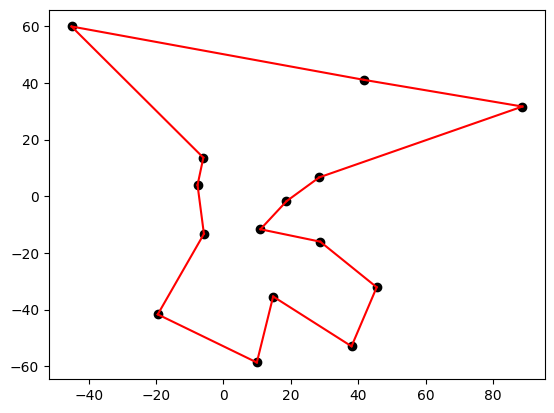

In [8]:
#utiliza a biblioteca matplotlib.pyplot 
#para gerar um grafico dos nos
pp.figure()

for pt in nos:
    pp.scatter(pt[0],pt[1],c='k')

for v in m.vars:
    if v.x > 1e-5:
        idx = [int(x) - 1 for x in v.name[3:-1].split(',') ]
        o = nos[idx[0]]
        d = nos[idx[1]]
        pp.plot([o[0],d[0]],[o[1],d[1]],'r')
        
pp.show()